In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

In [3]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

In [4]:
print("Training Data Shape:", train.shape)
print("Test Data Shape:", test.shape)

Training Data Shape: (891, 12)
Test Data Shape: (418, 11)


Printing dataset shapes

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

<Axes: >

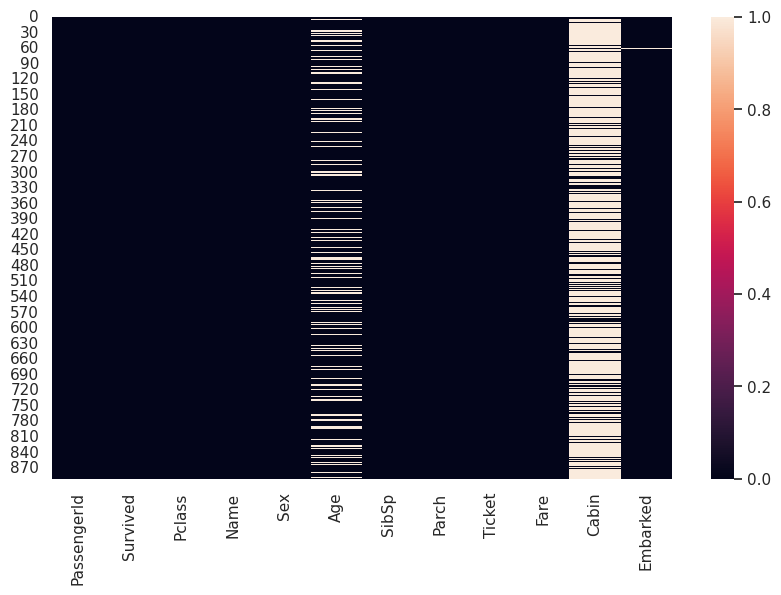

In [9]:
sns.heatmap(train.isna())

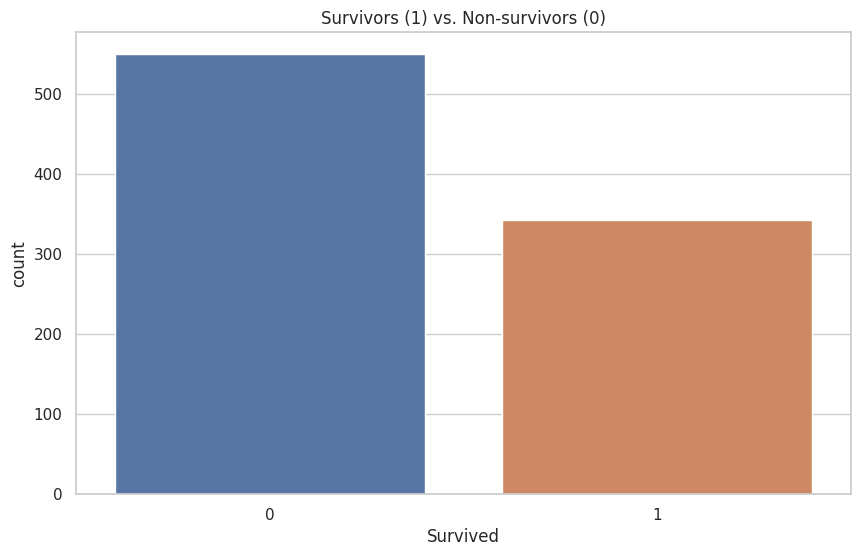

In [10]:
sns.countplot(x='Survived', data=train)
plt.title('Survivors (1) vs. Non-survivors (0)')
plt.show()

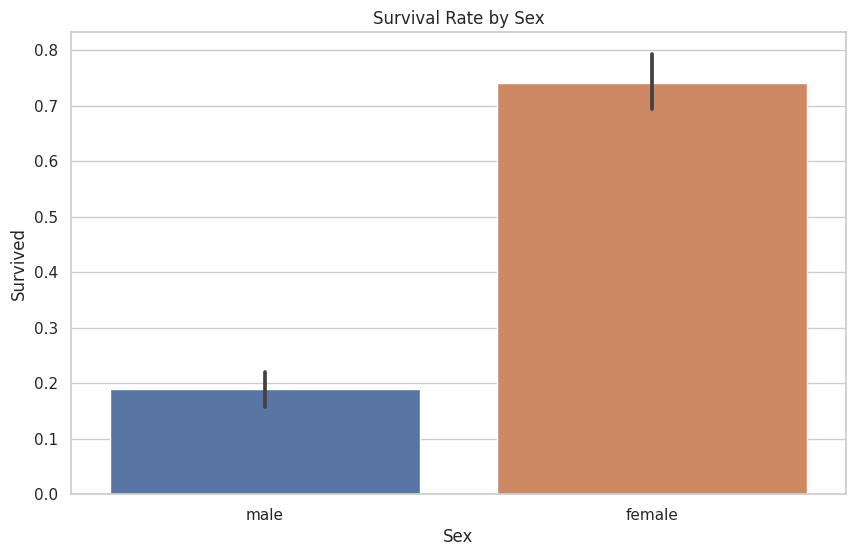

In [11]:
sns.barplot(x='Sex', y='Survived', data=train)
plt.title('Survival Rate by Sex')
plt.show()

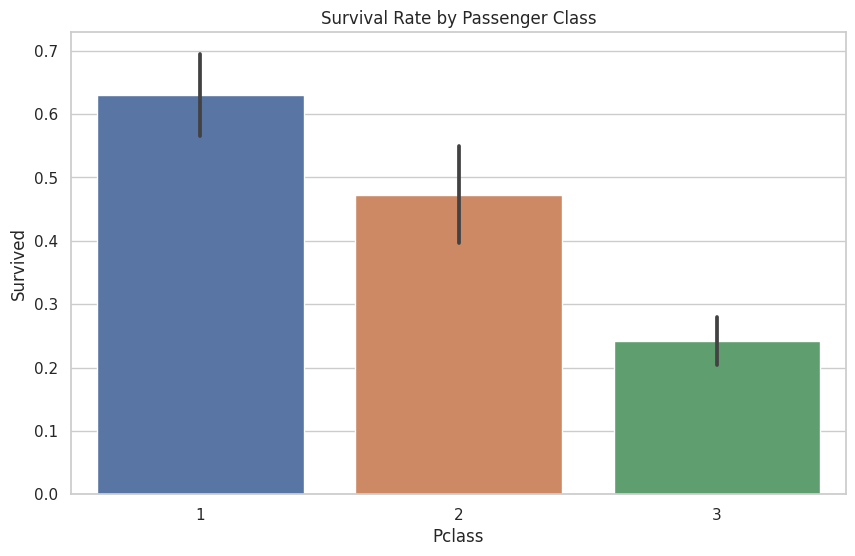

In [12]:
sns.barplot(x='Pclass', y='Survived', data=train)
plt.title('Survival Rate by Passenger Class')
plt.show()

Data Processing
Fill in missing age values with the median, fill in missing embarked values with the most common value

In [13]:
train['Age'] = train['Age'].fillna(train['Age'].median())
test['Age'] = test['Age'].fillna(test['Age'].median())

<Axes: >

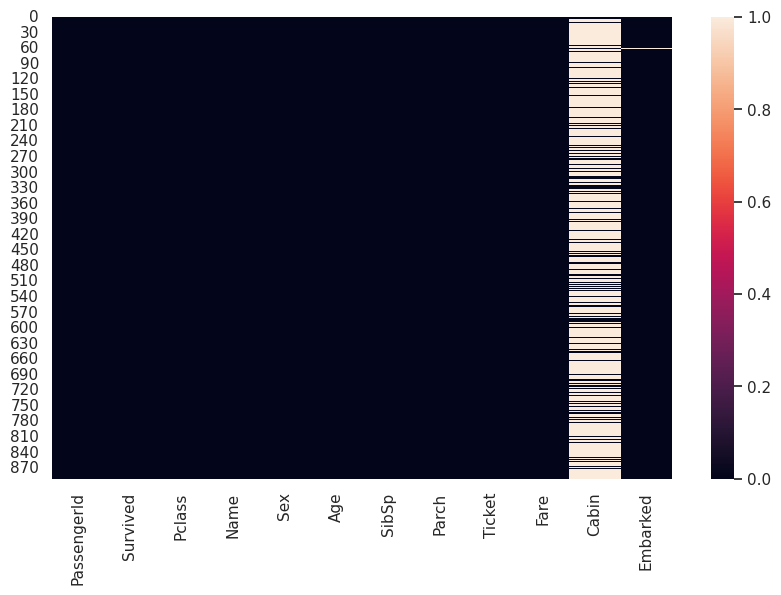

In [14]:
sns.heatmap(train.isna())

In [15]:
train['Embarked'] = train['Embarked'].fillna(train['Embarked'].mode()[0])
test['Embarked'] = test['Embarked'].fillna(test['Embarked'].mode()[0])

In [16]:
train.drop(['Cabin', 'Ticket', 'Name'], axis=1, inplace=True)
test.drop(['Cabin', 'Ticket', 'Name'], axis=1, inplace=True)

In [17]:
# For 'Sex', mapping 'female' to 0 and 'male' to 1:
train['Sex'] = train['Sex'].map({'female': 0, 'male': 1})
test['Sex'] = test['Sex'].map({'female': 0, 'male': 1})

# For 'Embarked', you might assign an integer to each unique value. For instance:
embarked_mapping = {'C': 0, 'Q': 1, 'S': 2}
train['Embarked'] = train['Embarked'].map(embarked_mapping)
test['Embarked'] = test['Embarked'].map(embarked_mapping)

In [18]:
print("Missing values in train:\n", train.isnull().sum())
print("Missing values in test:\n", test.isnull().sum())

Missing values in train:
 PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64
Missing values in test:
 PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           1
Embarked       0
dtype: int64


In [19]:
X = train.drop(['Survived', 'PassengerId'], axis=1)
y = train['Survived']

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [22]:
y_pred_logreg = logreg.predict(X_val)

Three Models: Logistic Regression, Decision Tree, and Random Forest

# Logistic Regression

In [23]:
print("Logistic Regression Accuracy:", accuracy_score(y_val, y_pred_logreg))
print(classification_report(y_val, y_pred_logreg))

Logistic Regression Accuracy: 0.8100558659217877
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       105
           1       0.79      0.74      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



# Decision Tree Classifier

In [24]:
dt = DecisionTreeClassifier(criterion='gini', max_depth=7, random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, random_state=42)

In [25]:
y_pred_dt = dt.predict(X_val)
print("Decision Tree Accuracy:", accuracy_score(y_val, y_pred_dt))
print(classification_report(y_val, y_pred_dt))

Decision Tree Accuracy: 0.7988826815642458
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       105
           1       0.82      0.66      0.73        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.79       179



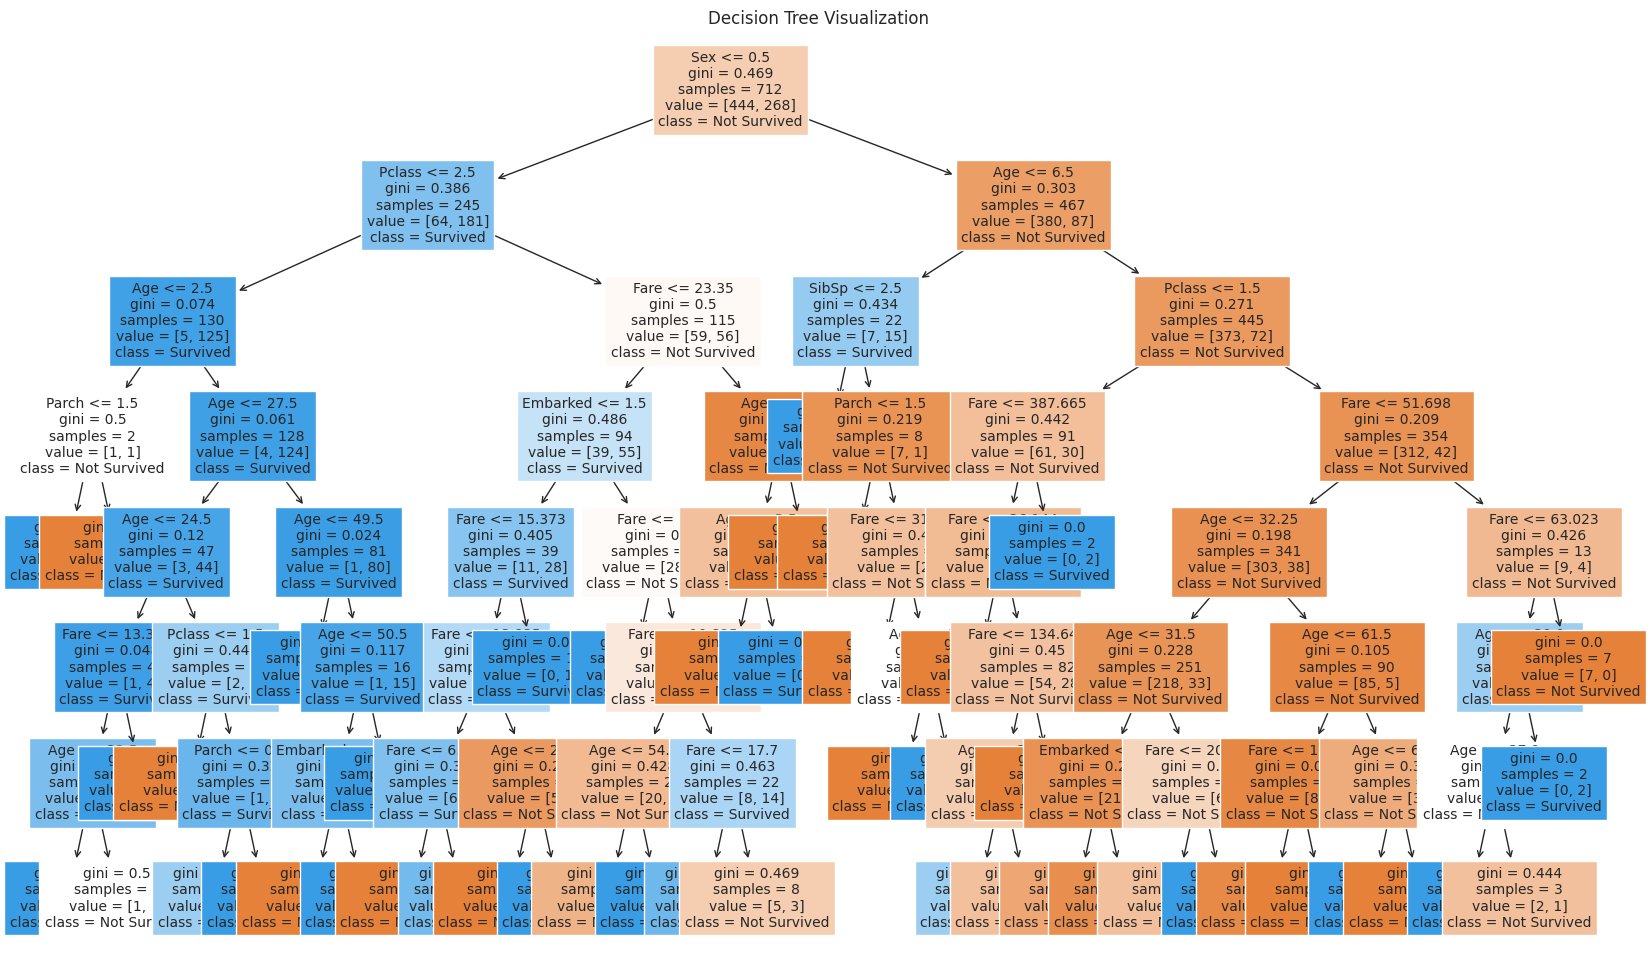

In [26]:
# Visualize the Decision Tree
plt.figure(figsize=(20, 12))
tree.plot_tree(
    dt, 
    feature_names=X.columns, 
    class_names=["Not Survived", "Survived"],  # Adjust labels as necessary
    filled=True,
    fontsize=10
)
plt.title("Decision Tree Visualization")
plt.show()

# Random Forest Classifier

In [27]:
rf = RandomForestClassifier(n_estimators=100,random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [28]:
y_pred_rf = rf.predict(X_val)
print("Random Forest Accuracy:", accuracy_score(y_val, y_pred_rf))
print(classification_report(y_val, y_pred_rf))

Random Forest Accuracy: 0.8212290502793296
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       105
           1       0.81      0.74      0.77        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



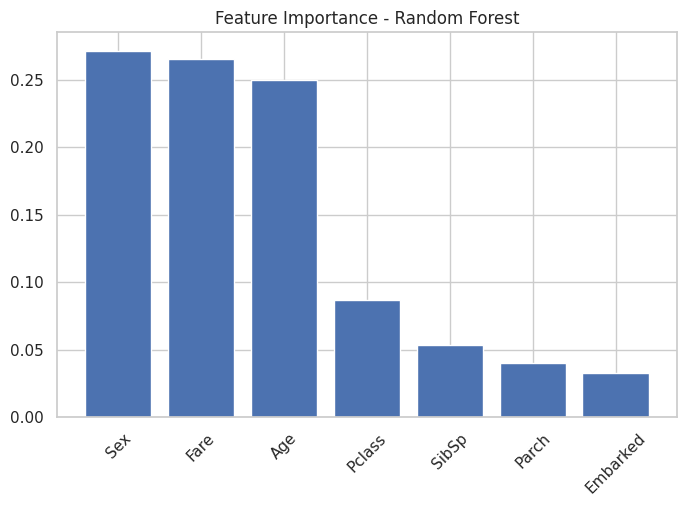

In [29]:
# Get feature importance scores
importances = rf.feature_importances_
feature_names = X.columns

# Plot feature importances
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(8, 5))
plt.title("Feature Importance - Random Forest")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), np.array(feature_names)[indices], rotation=45)
plt.show()

Using GridSearchCV to fine-tune the Decision Tree and Random Forest models.

In [30]:
param_grid_dt = {
    'max_depth': [None, 3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=5, scoring='accuracy')
grid_dt.fit(X_train, y_train)

print("Best Decision Tree Parameters:", grid_dt.best_params_)
print("Best Decision Tree CV Accuracy:", grid_dt.best_score_)

Best Decision Tree Parameters: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best Decision Tree CV Accuracy: 0.8230079779375554


In [31]:
best_dt = grid_dt.best_estimator_
y_pred_best_dt = best_dt.predict(X_val)
print("Tuned Decision Tree Accuracy:", accuracy_score(y_val, y_pred_best_dt))
print(classification_report(y_val, y_pred_best_dt))

Tuned Decision Tree Accuracy: 0.7988826815642458
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       105
           1       0.80      0.69      0.74        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



In [32]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 5, 7, 10],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [33]:
print("Best Random Forest Parameters:", grid_rf.best_params_)
print("Best Random Forest CV Accuracy:", grid_rf.best_score_)

Best Random Forest Parameters: {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best Random Forest CV Accuracy: 0.8328572835615089


In [34]:
best_rf = grid_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_val)
print("Tuned Random Forest Accuracy:", accuracy_score(y_val, y_pred_best_rf))
print(classification_report(y_val, y_pred_best_rf))

Tuned Random Forest Accuracy: 0.8268156424581006
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       105
           1       0.86      0.69      0.77        74

    accuracy                           0.83       179
   macro avg       0.84      0.81      0.81       179
weighted avg       0.83      0.83      0.82       179



Creating additional features(Family Size and AgeBand) and using cross validation to further validate the model.

In [35]:
def feature_engineering(df):
    # Create FamilySize as SibSp + Parch + 1 (for self)
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    
    # Create a new feature AgeBand by binning Age into 5 categories
    df['AgeBand'] = pd.cut(df['Age'], bins=5, labels=False)
    
    return df

In [36]:
train_fe = pd.read_csv('/kaggle/input/titanic/train.csv')
test_fe = pd.read_csv('/kaggle/input/titanic/test.csv')

In [37]:
train_fe['Age'] = train_fe['Age'].fillna(train_fe['Age'].median())
test_fe['Age'] = test_fe['Age'].fillna(test_fe['Age'].median())
test_fe['Fare'] = test_fe['Fare'].fillna(test_fe['Fare'].median())

In [38]:
print(train_fe.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [39]:
train_fe['Embarked'] = train_fe['Embarked'].fillna(train_fe['Embarked'].mode()[0])
test_fe['Embarked'] = test_fe['Embarked'].fillna(test_fe['Embarked'].mode()[0])

In [40]:
train_fe = feature_engineering(train_fe)
test_fe = feature_engineering(test_fe)

In [41]:
print(train_fe.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'FamilySize',
       'AgeBand'],
      dtype='object')


In [42]:
drop_cols = ['Cabin', 'Ticket', 'Name']
train_fe.drop(drop_cols, axis=1, inplace=True)
test_fe.drop(drop_cols, axis=1, inplace=True)

In [43]:
# For 'Sex', mapping 'female' to 0 and 'male' to 1:
train_fe['Sex'] = train_fe['Sex'].map({'female': 0, 'male': 1})
test_fe['Sex'] = test_fe['Sex'].map({'female': 0, 'male': 1})

# For 'Embarked', you might assign an integer to each unique value. For instance:
embarked_mapping = {'C': 0, 'Q': 1, 'S': 2}
train_fe['Embarked'] = train_fe['Embarked'].map(embarked_mapping)
test_fe['Embarked'] = test_fe['Embarked'].map(embarked_mapping)

In [44]:
X_fe = train_fe.drop(['Survived', 'PassengerId'], axis=1)
y_fe = train_fe['Survived']

In [45]:
from sklearn.model_selection import cross_val_score

# Use the best parameters found from previous GridSearch (or re-run tuning on feature engineered data)
# For this example, we reinitialize our tuned Random Forest with previously selected parameters.
best_rf_final = RandomForestClassifier(
    n_estimators=grid_rf.best_params_['n_estimators'],
    max_depth=grid_rf.best_params_['max_depth'],
    min_samples_split=grid_rf.best_params_['min_samples_split'],
    min_samples_leaf=grid_rf.best_params_['min_samples_leaf'],
    bootstrap=grid_rf.best_params_['bootstrap'],
    random_state=42
)

In [46]:
cv_scores = cross_val_score(best_rf_final, X_fe, y_fe, cv=5, scoring='accuracy')
print("5-Fold Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy: {:.4f}".format(cv_scores.mean()))

5-Fold Cross-Validation Accuracy Scores: [0.80446927 0.82022472 0.83707865 0.79775281 0.84269663]
Mean CV Accuracy: 0.8204


In [47]:
best_rf_final.fit(X_fe, y_fe)

RandomForestClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=5,
                       random_state=42)

In [48]:
X_test = test_fe.drop(['PassengerId'], axis=1)

In [49]:
print(test_fe.isnull().sum())

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
FamilySize     0
AgeBand        0
dtype: int64


In [50]:
test_predictions = best_rf_final.predict(X_test)

In [51]:
# Create submission DataFrame
submission = pd.DataFrame({
    "PassengerId": test_fe["PassengerId"],
    "Survived": test_predictions
})

# Save the submission file
submission.to_csv("submission.csv", index=False)
print("Submission file created successfully!")

Submission file created successfully!
